In [1]:
from collections import deque

import random
import pickle
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
G = nx.Graph()

V = list(range(16))
E = [[ 0,  1], [ 0,  3], [ 1,  2], [ 2,  3],
     [ 1,  4], [ 1,  6], [ 3,  8], [ 3, 10],
     [ 4,  5], [ 4,  7], [ 5,  6], [ 6,  7],
     [ 8,  9], [ 8, 11], [ 9, 10], [10, 11],
     [ 5, 12], [ 7, 12], [ 9, 14], [11, 14],
     [12, 13], [12, 15], [13, 14], [14, 15]]

positions = [(-1, 0), (1, 0), (-1, -1), (1, -1),
             (2,0.25), (3, 0.25), (2, -0.25), (3, -0.25),
             (2,-0.75), (3, -0.75), (2, -1.25), (3, -1.25),
             (4,  0), (6, 0), (4, -1), (6, -1)]

for v in V:
    G.add_node(v, pos=positions[v])

G.add_edges_from(E)

pos = nx.get_node_attributes(G, 'pos')

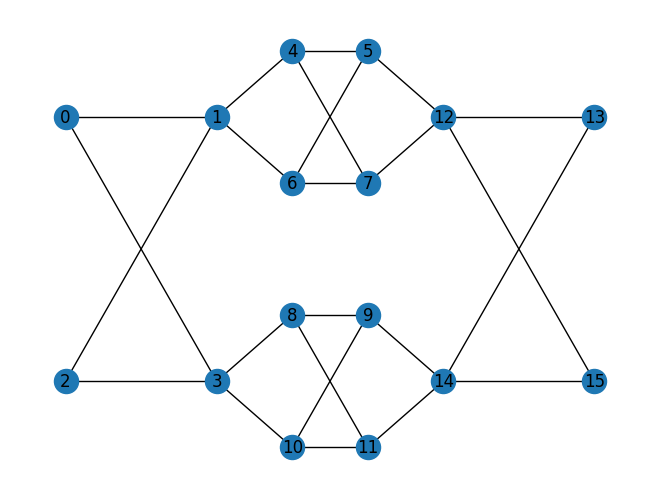

In [4]:
nx.draw(G, pos, with_labels=True)
plt.show()

In [5]:
# Для каждой вершины формируем множество вершин, в которые можно попасть из данной
E_v = [set() for _ in V]

for e in np.concatenate([E, np.flip(E, axis=1)]):
    E_v[e[0]].add(e[1])

E_v = [list(E_v[v]) for v in V]
E_v

[[1, 3],
 [0, 2, 4, 6],
 [1, 3],
 [8, 0, 10, 2],
 [1, 5, 7],
 [12, 4, 6],
 [1, 5, 7],
 [12, 4, 6],
 [3, 9, 11],
 [8, 10, 14],
 [3, 9, 11],
 [8, 10, 14],
 [5, 7, 13, 15],
 [12, 14],
 [9, 11, 13, 15],
 [12, 14]]

In [6]:
# Находит множество путей в графе из вершины start в вершину end без циклов
def find_paths(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return [path]
    if start not in graph:
        return []
    paths = []
    for node in graph[start]:
        if node not in path:
            new_paths = find_paths(graph, node, end, path)
            for new_path in new_paths:
                paths.append(new_path)
    return paths


# Находит множество допустимых вершин для построенного множества путей valid_paths и текущего маршрута current_route
def find_next_vertices(valid_paths, current_route):
    next_vertices = set()

    for path in valid_paths:
        if len(path) > len(current_route) and path[:len(current_route)] == current_route:
            next_vertex = path[len(current_route)]
            next_vertices.add(next_vertex)

    return next_vertices

In [7]:
# Формирование множеств путей для каждого потока (v_src, v_dst) в графе без циклов
# paths[v_src][v_dst]
paths =  [None] * len(V)
for v_src in range(len(V)):
    paths[v_src] =  [None] * len(V)
    for v_dst in range(len(V)):
        if v_src != v_dst:
            paths[v_src][v_dst] = find_paths(G, v_src, v_dst)

In [8]:
μ = 1          # Параметр интенсивности обслуживания каждого выходного порта коммутатора
S = 5          # Максимальный размер очереди

In [9]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [10]:
λ = np.random.rand(len(V), len(V)).round(2) / 2   # Параметры интенсивности каждого потока
np.fill_diagonal(λ, 0)                            # Диагональные элементы не используются
λ

array([[0.   , 0.475, 0.365, 0.3  , 0.08 , 0.08 , 0.03 , 0.435, 0.3  ,
        0.355, 0.01 , 0.485, 0.415, 0.105, 0.09 , 0.09 ],
       [0.15 , 0.   , 0.215, 0.145, 0.305, 0.07 , 0.145, 0.185, 0.23 ,
        0.395, 0.1  , 0.255, 0.295, 0.025, 0.305, 0.085],
       [0.035, 0.475, 0.   , 0.405, 0.15 , 0.05 , 0.34 , 0.22 , 0.06 ,
        0.25 , 0.015, 0.455, 0.13 , 0.33 , 0.155, 0.26 ],
       [0.275, 0.09 , 0.485, 0.   , 0.47 , 0.445, 0.3  , 0.46 , 0.045,
        0.1  , 0.025, 0.165, 0.195, 0.135, 0.415, 0.18 ],
       [0.14 , 0.27 , 0.07 , 0.4  , 0.   , 0.495, 0.385, 0.1  , 0.005,
        0.41 , 0.355, 0.365, 0.385, 0.035, 0.18 , 0.06 ],
       [0.43 , 0.31 , 0.165, 0.03 , 0.155, 0.   , 0.365, 0.32 , 0.445,
        0.235, 0.06 , 0.355, 0.38 , 0.28 , 0.385, 0.245],
       [0.26 , 0.215, 0.015, 0.055, 0.015, 0.32 , 0.   , 0.255, 0.455,
        0.125, 0.205, 0.38 , 0.115, 0.04 , 0.145, 0.08 ],
       [0.465, 0.405, 0.315, 0.435, 0.4  , 0.095, 0.445, 0.   , 0.405,
        0.45 , 0.16 , 0.05

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
# DQN Agent
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions):
        super().__init__()
        self.n_actions = n_actions
        self.state_shape = state_shape

        self.network = nn.Sequential(
            nn.Linear(state_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
        )

    def forward(self, x):
        return self.network(x)

    def get_action(self, state, E_v, E_valid, device=device):
        state_t = torch.tensor(state, device=device, dtype=torch.float32)
        mask = np.zeros(self.n_actions)
        invalid_idxs = [E_v.index(idx) for idx in list(set(E_v) - E_valid)]
        mask[invalid_idxs] = -float("Inf")
        return (self.forward(state_t).detach().cpu().numpy() + mask).argmax()

    def eps_greedy_action(self, state, epsilon, E_v, E_valid, device=device):
        if random.random() < epsilon:
            action = E_v.index(np.random.choice(list(E_valid)))
        else:
            action = self.get_action(state, E_v, E_valid)
        return action


# Replay Buffer
class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = deque(maxlen=size)

    def __len__(self):
        return len(self._storage)

    def add(self, transition):
        self._storage.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self._storage, batch_size)
        states, actions, rewards, next_states = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states)

In [13]:
#state_dim = 4 * len(V) + 2 * len(E)

agents = [None] * len(V)
target_networks = [None] * len(V)

for v in V:
    state_dim = 4 * len(V) + len(E_v[v])        ####################
    n_actions = len(E_v[v])
    agents[v] = DQNAgent(state_dim, n_actions).to(device)
    target_networks[v] = DQNAgent(state_dim, n_actions).to(device)
    target_networks[v].load_state_dict(agents[v].state_dict())

optimizers = [torch.optim.Adam(agents[v].parameters(), lr=1e-4) for v in V]
exp_replays = [ReplayBuffer(2000) for v in V]

In [14]:
# Возвращает temporal difference loss
def compute_td_loss(states, actions, rewards, next_states,
                    agent, target_network, gamma=0.5, device=device):

    states = torch.tensor(states, device=device, dtype=torch.float32)                # shape: [batch_size, state_dim]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)                # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)              # shape: [batch_size]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)        # shape: [batch_size, state_dim]

    predicted_qvalues = agent(states)                                                # shape: [batch_size, n_actions]
    predicted_next_qvalues = target_network(next_states)                             # shape: [batch_size, n_actions]
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]
    next_state_values = predicted_next_qvalues.max(axis=1).values
    target_qvalues_for_actions = rewards + gamma * next_state_values
    return torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2) #loss


# Рассчитывает среднюю длину очереди каждого выходного порта
def loading_queue(ρ, s):
    return np.sum([k * ρ ** (k + 1) for k in range(1, s + 1)], axis=0) / np.sum([(ρ ** k) for k in range(s + 2)], axis=0)


# Возвращает OHE-вектор для потока (v_src, v_dst)
def OHE_thread(v_src, v_dst):
    OHE_n = np.zeros((2, len(V)))
    OHE_n[0, v_src] = 1
    OHE_n[1, v_dst] = 1
    return OHE_n.reshape(-1)


# Рассчитывает epsilon на текущем шаге step
def linear_decay(init_epsilon, final_epsilon, step, decay_steps):
    return max(init_epsilon - step * (init_epsilon - final_epsilon) / decay_steps, final_epsilon)


# Возвращает загруженность L[v] выходных портов q коммутатора v
# основываясь на информации N[v] о поступающих потоках на коммутатор v
def calculate_queues_load(N, v):
    λ_v = np.zeros(len(E_v[v]))
    np.add.at(λ_v, N[v]['q'], λ[N[v]['n'][:, 0], N[v]['n'][:, 1]])
    return loading_queue(λ_v / μ, S) / S


# Принимает загруженности очередей коммутаторов L[v][q]. Возвращает reward
def get_reward(L):
    L_concat = np.concatenate(L)
    return 1 - np.sqrt(((L_concat - L_concat.mean()) ** 2).mean())


# Генерирует потоки в сети: возвращает матрицу размера (T, 3) со столбцами (v_src, v_dst, dt)
def generate_treads(T):
    Times = np.zeros((T, 3), dtype=int)
    Times[:, 0:2] = np.random.randint(0, len(V) - 1, (T, 2))    # v_src, v_dst
    mask = Times[:, 0] == Times[:, 1]

    while np.any(mask):
        Times[:, 0:2][mask] = np.random.randint(0, len(V) - 1, (np.sum(mask), 2))
        mask = Times[:, 0] == Times[:, 1]

    Times[:, 2] = np.random.randint(2, 8, size=T)               # dt
    return Times

In [15]:
# Гиперпараметры метода DQN

batch_size = 256
total_steps = 50_001

decay_steps = 30_000
init_epsilon = 1
final_epsilon = 0.02

loss_freq = 400
refresh_target_network_freq = 100
eval_freq = 400

max_grad_norm = 50

In [16]:
# Загруженность оцередей каждого коммутатора L[v][q]
L = [np.zeros(len(E_v[v])) for v in range(len(V))]

# Это тройка массивов [n, q, t] для каждого коммутатора v (содержит информацию о поступающих потоках на коммутаторы), где
#   n = (v_src, v_dst) - потоки, поступающие на коммутатор v;
#   q - выходные порты, на который отправляются пакеты потоков n (0, 1, 2, ...);
#   t - оставшееся время поступления пакетов потоков n.
N = [{'n': np.zeros((0, 2), dtype=np.int32),
      'q': np.zeros(0, dtype=np.int32),
      't': np.zeros(0, dtype=np.int32)} for _ in range(len(V))]

Times = generate_treads(total_steps)

In [17]:
# Уменьшение оставшегося времени dt и удаление из массивов потоков с (dt = 0)
def update_N(N):
    for v in V:
        N[v]['t'] = N[v]['t'] - 1
        non_zero_idxs = np.where(N[v]['t'] != 0)[0]
        N[v]['n'] = N[v]['n'][non_zero_idxs]
        N[v]['q'] = N[v]['q'][non_zero_idxs]
        N[v]['t'] = N[v]['t'][non_zero_idxs]

# Добавление нового потока с его характеристиками [(v_src, v_dst), q, t]
def add_thread_N(N_v, v_src, v_dst, action, dt):
    N_v['n'] = np.vstack([N_v['n'], [v_src, v_dst]])
    N_v['q'] = np.append(N_v['q'], action)
    N_v['t'] = np.append(N_v['t'], dt)

# Создание валидационной выборки для оценки качества

In [18]:
# Рассчитывает максимальный ('argmax') или минимальный ('argmin') reward, выбирая оптимальные действия на каждом шаге t
def get_max_min_optimal_reward(Times, optimal='argmax', verbose=False):
    L = [np.zeros(len(E_v[v])) for v in range(len(V))]
    N = [{'n': np.zeros((0, 2), dtype=np.int32),
           'q': np.zeros(0, dtype=np.int32),
           't': np.zeros(0, dtype=np.int32)} for _ in range(len(V))]
    optimal_rewards = []

    T = Times.shape[0]
    for t in range(T):
        v_src, v_dst, dt = Times[t]

        rewards_t = []
        N_t = [copy.deepcopy(N) for _ in range(len(paths[v_src][v_dst]))]
        for i, path in enumerate(paths[v_src][v_dst]):
            for k in range(len(path) - 1):
                # Добавление нового потока с его характеристиками [(v_src, v_dst), q, t]
                v = path[k]
                action = E_v[v].index(path[k + 1])
                add_thread_N(N_t[i][v], v_src, v_dst, action, dt)

            L = [calculate_queues_load(N_t[i], v) for v in V]
            rewards_t.append(get_reward(L))

        if optimal == 'argmax': best_route = np.argmax(rewards_t)
        if optimal == 'argmin': best_route = np.argmin(rewards_t)
        if verbose:
            print(f"t = {t}\t reward = {round(rewards_t[best_route], 3)}\t route = {paths[v_src][v_dst][best_route]}")
        N = copy.deepcopy(N_t[best_route])
        optimal_rewards.append(rewards_t[best_route])

        # Уменьшение оставшегося времени dt и удаление из массивов потоков с (dt = 0)
        update_N(N)

        L = [calculate_queues_load(N, v) for v in V]

    return sum(optimal_rewards)

In [19]:
# Оценивает среднюю награду на валидационной выборке потоков Times (Действия выбираются только жадно)
def evaluate(Times):
    L = [np.zeros(len(E_v[v])) for v in range(len(V))]
    N = [{'n': np.zeros((0, 2), dtype=np.int32),
          'q': np.zeros(0, dtype=np.int32),
          't': np.zeros(0, dtype=np.int32)} for _ in range(len(V))]
    rewards = []

    T = Times.shape[0]
    for t in range(T):
        v_src, v_dst, dt = Times[t]
        v = v_src

        route = []
        while v != v_dst:
            route.append(v)

            # Формирование состояния для подачи на вход нейронке:
            # OHE поступающего потока | Sum OHE всех поступающих потоков на коммутатор | Загруженность во всей сети L
            OHE_threads = np.zeros(2 * len(V)) + np.sum([OHE_thread(v_src, v_dst) for (v_src, v_dst) in N[v]['n']], axis=0)
            #state = np.concatenate([OHE_thread(v_src, v_dst), OHE_threads, np.concatenate(L)])
            state = np.concatenate([OHE_thread(v_src, v_dst), OHE_threads, L[v]])               ####################

            # Выбор действия жадно
            E_valid = find_next_vertices(paths[v_src][v_dst], route)
            action = agents[v].get_action(state, E_v[v], E_valid)

            # Добавление нового потока с его характеристиками [(v_src, v_dst), q, t]
            add_thread_N(N[v], v_src, v_dst, action, dt)

            # Рассчитывает загруженность L[v] для каждого выходного порта q коммутатора v
            L[v] = calculate_queues_load(N, v)

            # Переход на выбранный коммутатор
            v = E_v[v][action]

        # Расчет награды и ее добавление в список
        rewards.append(get_reward(L))

        # Уменьшение оставшегося времени dt и удаление из массивов потоков с (dt = 0)
        update_N(N)

        L = [calculate_queues_load(N, v) for v in V]

    return sum(rewards) / T

In [20]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [21]:
T = 100    # t = 0..T, T - общее количество временных шагов
Times_test = generate_treads(T)

max_reward = get_max_min_optimal_reward(Times_test, 'argmax') / T
min_reward = get_max_min_optimal_reward(Times_test, 'argmin') / T

print(f"max reward = {max_reward}")
print(f"min reward = {min_reward}")

max reward = 0.981683969696657
min reward = 0.8852775803506195


# Обучение

In [22]:
transitions = [[] for _ in V]

PATH = f'/content/drive/MyDrive/marl/5/'
MAX_reward = 0

loss_values = []
reward_values = []

for t in range(total_steps):
    v_src, v_dst, dt = Times[t]
    v = v_src

    route = []
    while v != v_dst:
        route.append(v)

        # Формирование состояния для подачи на вход нейронке:
        # OHE поступающего потока | Sum всех OHE поступающих потоков на коммутатор | Загруженность во всей сети L
        OHE_threads = np.zeros(2 * len(V)) + np.sum([OHE_thread(v_src, v_dst) for (v_src, v_dst) in N[v]['n']], axis=0)
        #state = np.concatenate([OHE_thread(v_src, v_dst), OHE_threads, np.concatenate(L)])
        state = np.concatenate([OHE_thread(v_src, v_dst), OHE_threads, L[v]])               ###################

        # Выбор действия. eps-жадная стратегия
        E_valid = find_next_vertices(paths[v_src][v_dst], route)
        epsilon = linear_decay(init_epsilon, final_epsilon, t, decay_steps)
        action = agents[v].eps_greedy_action(state, epsilon, E_v[v], E_valid)

        # Добавление нового потока с его характеристиками [(v_src, v_dst), q, t]
        add_thread_N(N[v], v_src, v_dst, action, dt)

        # Рассчитывает загруженность L[v] для каждого выходного порта q коммутатора v
        L[v] = calculate_queues_load(N, v)

        if len(transitions[v]) > 0:
            transitions[v].append(state)  #next_state
            exp_replays[v].add(transitions[v])
        transitions[v] = [state, action]

        v = E_v[v][action]

    # Расчет награды и добавление ее в переходы всем агентам маршрута
    reward = get_reward(L)
    for v in route:
        transitions[v].append(reward)

    # Уменьшение оставшегося времени dt и удаление из массивов потоков с (dt = 0)
    update_N(N)

    # Рассчитывает загруженность L[v][q] для каждого выходного порта q коммутатора v
    L = [calculate_queues_load(N, v) for v in V]

    # Обучение каждого коммутатора отдельно
    losses = []
    for v in V:
        if len(exp_replays[v]) >= batch_size:
            states, actions, rewards, next_states = exp_replays[v].sample(batch_size)
            loss = compute_td_loss(states, actions, rewards, next_states, agents[v], target_networks[v])

            loss.backward()
            if t % loss_freq == 0:
                losses.append(loss.data.cpu().item())
            grad_norm = nn.utils.clip_grad_norm_(agents[v].parameters(), max_grad_norm)
            optimizers[v].step()
            optimizers[v].zero_grad()

            # Каждые refresh_target_network_freq обновляются веса ОДНОЙ target сети
            # (Добавляет некоторую стабильность по сравнению с тем, если бы они обновлялись все разом)
            if t % refresh_target_network_freq == 0:
                for v in V:
                    if t % (refresh_target_network_freq * len(V)) == refresh_target_network_freq * v:
                        target_networks[v].load_state_dict(agents[v].state_dict())

    # Вывод лосса с заданной частотой
    if t % loss_freq == 0:
        loss_values.append(losses)
        losses = np.array(losses).round(5)
        print(f"t = {str(t):5}\t losses = {losses}")

    # Вывод масштабированной награды на валидационной выборке с заданной частотой
    if t % eval_freq == 0:
        scaled_reward = (evaluate(Times_test) - min_reward) / (max_reward - min_reward)
        reward_values.append(scaled_reward)
        print(f"t = {str(t):5}\t reward = {round(scaled_reward, 4)}\t eps = {round(epsilon, 4)}\n")

        if scaled_reward > MAX_reward:
            MAX_reward = scaled_reward
            for v in V:
                torch.save(agents[v].state_dict(), PATH + f'model_{v}')
                torch.save(optimizers[v].state_dict(), PATH + f'opt_{v}')

t = 0    	 losses = []
t = 0    	 reward = 0.5823	 eps = 1.0

t = 400  	 losses = []
t = 400  	 reward = 0.5823	 eps = 0.9869

t = 800  	 losses = [0.00432 0.00502 0.02825 0.01918 0.01821 0.03862 0.25671 0.02897 0.01822
 0.02392 0.00641 0.0051 ]
t = 800  	 reward = 0.7123	 eps = 0.9739

t = 1200 	 losses = [0.00155 0.00073 0.00339 0.00085 0.00102 0.00105 0.00122 0.00283 0.00283
 0.00258 0.00257 0.00244 0.23134 0.00687 0.00084 0.01274]
t = 1200 	 reward = 0.7156	 eps = 0.9608

t = 1600 	 losses = [0.00047 0.00057 0.00083 0.00074 0.00063 0.00076 0.00057 0.00243 0.00202
 0.00143 0.00106 0.00138 0.00116 0.00134 0.00137 0.00099]
t = 1600 	 reward = 0.7721	 eps = 0.9477

t = 2000 	 losses = [0.00079 0.00108 0.00078 0.00181 0.22154 0.0005  0.00038 0.00147 0.00172
 0.00101 0.00066 0.00078 0.00078 0.00081 0.00114 0.00075]
t = 2000 	 reward = 0.7744	 eps = 0.9347

t = 2400 	 losses = [0.00055 0.00064 0.00044 0.00096 0.00074 0.0006  0.00081 0.00166 0.06396
 0.00132 0.00078 0.00084 0.00047 0.00057

In [23]:
#Соранение моделей и оптимизаторов (списки rewards & losses)

with open(f'{PATH}data.pickle', 'wb') as f:
   pickle.dump((reward_values, loss_values), f)

# Построение графиков зависимостей $r(t)$, $Loss(t)$

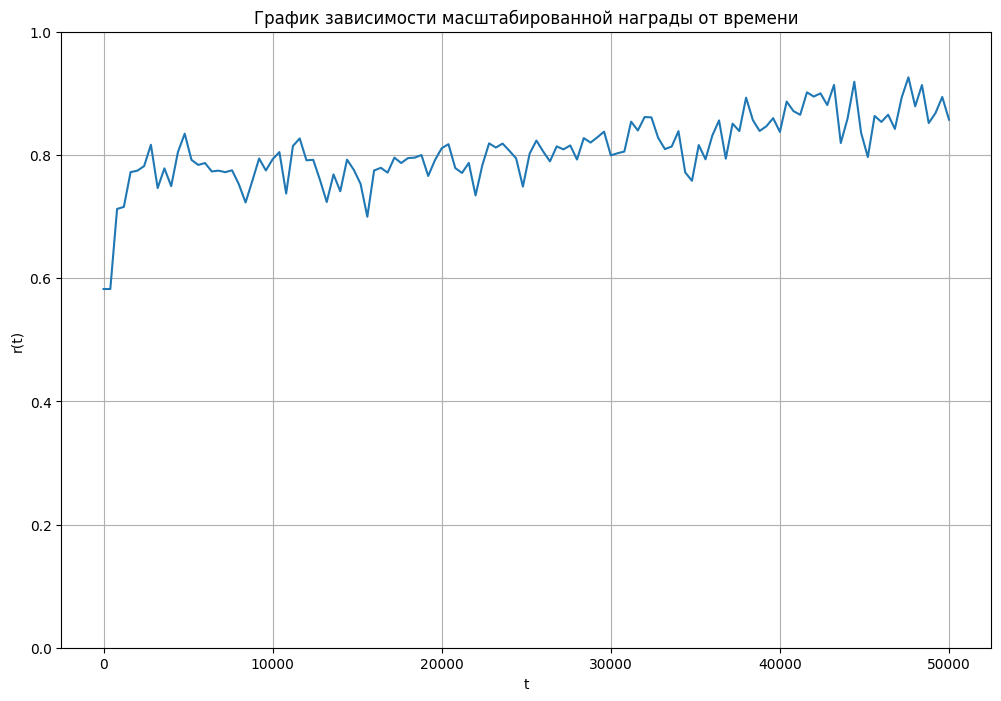

In [24]:
x = range(0, total_steps, eval_freq)

plt.figure(figsize=(12, 8))
plt.title('График зависимости масштабированной награды от времени')
plt.xlabel('t')
plt.ylabel('r(t)')
plt.grid()
plt.ylim([0, 1])
plt.plot(x, reward_values)
plt.show()

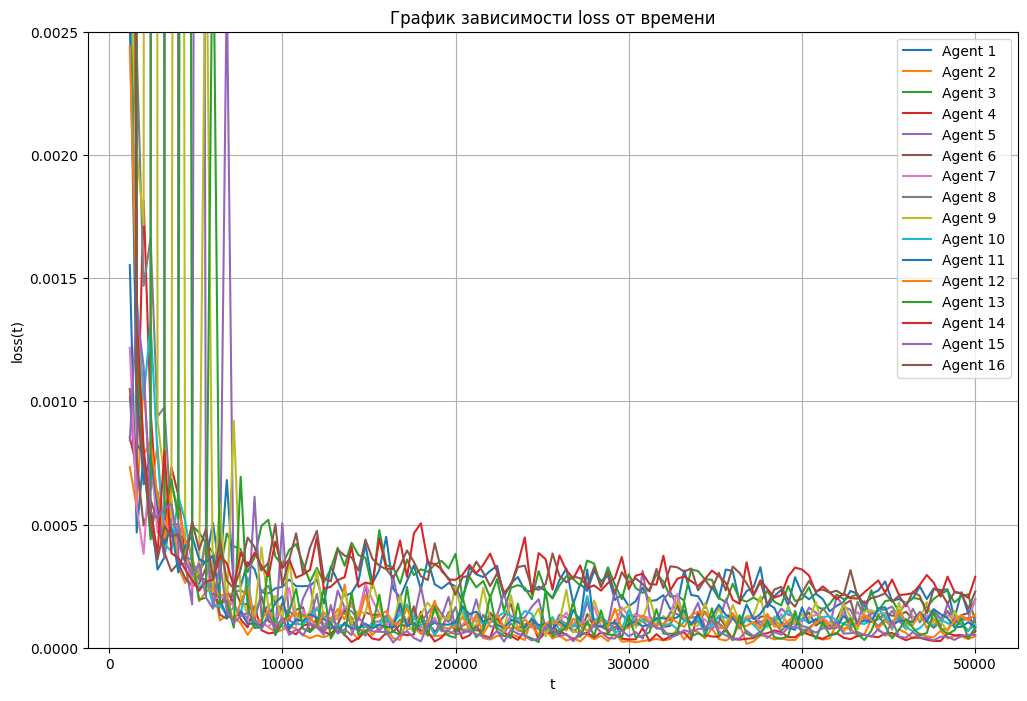

In [25]:
n_delete = 3  # Начинаем с индекса 3, так как ранее не для всех агентов еще был рассчитан loss
loss_values = np.array(loss_values[n_delete:]).T
x = range(n_delete*loss_freq, total_steps, loss_freq)

plt.figure(figsize=(12, 8))
plt.grid()
plt.ylim([0, 0.0025])
plt.title('График зависимости loss от времени')
plt.xlabel('t')
plt.ylabel('loss(t)')

for i, loss in enumerate(loss_values):
    plt.plot(x, loss, label=f'Agent {i+1}')

plt.legend()
plt.show()

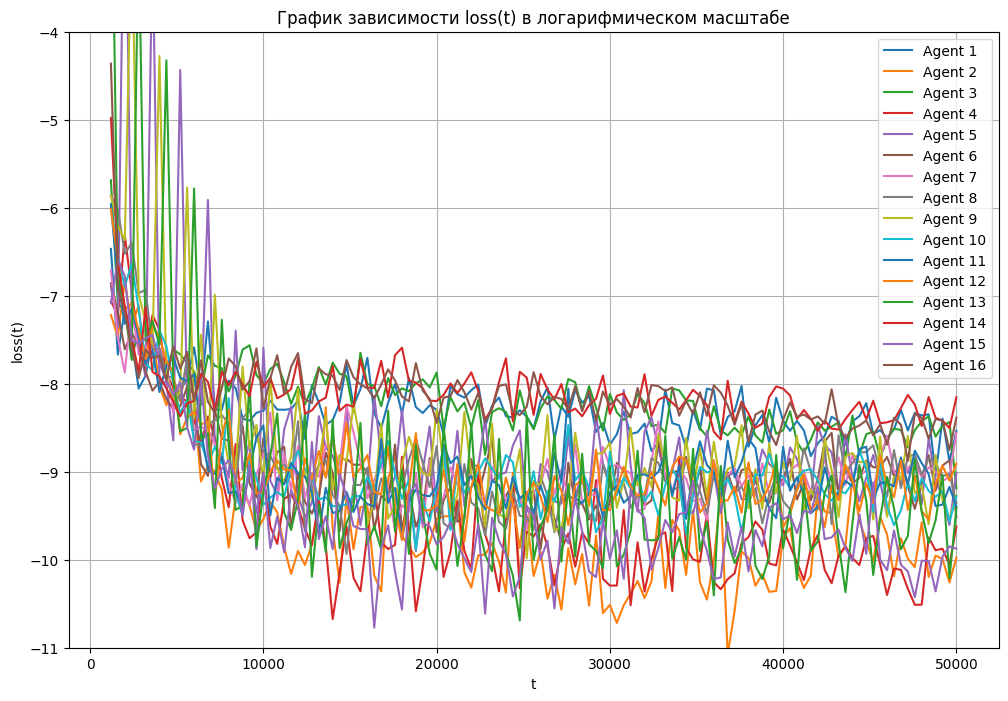

In [26]:
log_losses = np.log(loss_values)

plt.figure(figsize=(12, 8))
plt.grid()
plt.ylim([-11, -4])
plt.title('График зависимости loss(t) в логарифмическом масштабе')
plt.xlabel('t')
plt.ylabel('loss(t)')

for i, losses in enumerate(log_losses):
    plt.plot(x, losses, label=f'Agent {i+1}')

plt.legend()
plt.show()

#Визуализация графа сети

In [27]:
# Визуализирует текущее состояние сети. Принимает на вход граф G, информацию о поступающих потоках N.
# Есть возможность выделить маршрут отдельного потока selected_thread=[v_src, v_dst], передав его третьим аргументом
def visualize(G, N, selected_thread=None):
    G = G.to_directed()
    L = [calculate_queues_load(N, v) for v in V]

    # --- Вершины ---
    for u, v in G.edges:
        G[u][v]['weight'] = 0

    # --- Веса вершин ---
    for v_src in V:
        for v_dst in E_v[v_src]:
            G[v_src][v_dst]['weight'] = round(L[v_src][E_v[v_src].index(v_dst)], 3)

    # --- Цвета ---
    for u, v in G.edges:
        G[u][v]['color'] = 'black'

    # --- Выделение маршрута selected_thread ---
    if selected_thread is not None:
        for v_src in V:
            idxs = np.where(np.all(N[v_src]['n'] == selected_thread, axis=1))[0]
            idxs_dst = N[v_src]['q'][idxs]
            for v_dst in np.array(E_v[v_src])[idxs_dst]:
                G[v_src][v_dst]['color'] = 'y'
                G[v_dst][v_src]['color'] = 'y'

    # --- Списки вершин и цветов ---
    colors = nx.get_edge_attributes(G, 'color').values()
    weights = nx.get_edge_attributes(G, 'weight')

    # --- Вывод информации о потоках ---
    print("Текущие потоки в сети:")
    all_n = np.vstack([N[v]['n'] for v in V])
    for (v_src, v_dst) in np.unique(all_n, axis=0):
        print(f"Поток = ({v_src} -> {v_dst}), L = {round(loading_queue(λ[v_src, v_dst] / μ, S) / S, 3)}")

    print()
    if selected_thread is not None:
        v_src, v_dst = selected_thread
        print(f'Выделенный поток = ({v_src} -> {v_dst}), L = {round(loading_queue(λ[v_src, v_dst] / μ, S) / S, 3)}')
    print(f"L_mean = {round(np.concatenate(L).mean(), 4)}, reward = {round(get_reward(L), 4)}")

    # --- Визуализация графа ---
    nx.draw(G, pos, with_labels=True, edge_color=colors)
    nx.draw_networkx_edge_labels(G, pos, weights, label_pos=0.66)
    plt.show()

# Тестирование и анализ обученных агентов на новой выборке потоков

In [28]:
# Загрузка сохраненных моделей и параметров оптимизаторов
PATH = f'/content/drive/MyDrive/marl/5/'
for v in V:
    agents[v].load_state_dict(torch.load(PATH + f'model_{v}'))
    optimizers[v].load_state_dict(torch.load(PATH + f'opt_{v}'))

In [29]:
# with open(f'{PATH}data.pickle', 'rb') as f:
#     data_new = pickle.load(f)

In [30]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [31]:
T = 100    # t = 0..T, T - общее количество временных шагов
Times_test = generate_treads(T)

In [32]:
# Создает массив N(t), сохраняющий поступающие потоки в каждый момент времени t, для анализа

L = [np.zeros(len(E_v[v])) for v in range(len(V))]
N = [[{'n': np.zeros((0, 2), dtype=np.int32),
       'q': np.zeros(0, dtype=np.int32),
       't': np.zeros(0, dtype=np.int32)} for _ in range(len(V))] for _ in range(T)]

transitions = [[] for _ in V]
rewards = []

for t in range(T):
    print(f"t = {t}, thread = {Times_test[t][0:2]}", end='\t')
    v_src, v_dst, dt = Times_test[t]

    route = []
    v = v_src
    while v != v_dst:
        route.append(v)

        # Формирование состояния для подачи на вход нейронке:
        # OHE поступающего потока | Sum всех OHE поступающих потоков на коммутатор | Загруженность во всей сети L
        OHE_threads = np.zeros(2 * len(V)) + np.sum([OHE_thread(v_src, v_dst) for (v_src, v_dst) in N[t][v]['n']], axis=0)
        #state = np.concatenate([OHE_thread(v_src, v_dst), OHE_threads, np.concatenate(L)])                                   ####################
        state = np.concatenate([OHE_thread(v_src, v_dst), OHE_threads, L[v]])

        # Выбор действия жадно
        E_valid = find_next_vertices(paths[v_src][v_dst], route)
        action = agents[v].get_action(state, E_v[v], E_valid)

        # Добавление нового потока с его характеристиками [(v_src, v_dst), q, t]
        add_thread_N(N[t][v], v_src, v_dst, action, dt)

        # Рассчитывает загруженность L[v] для каждого выходного порта q коммутатора v
        L[v] = calculate_queues_load(N[t], v)

        v = E_v[v][action]

    # Расчет награды и возвращение ее в переходы всем агентам
    reward = get_reward(L)
    print(f"reward = {round(reward, 4)}", end='\t')
    print(f"route = {route}", end='\t')
    rewards.append(reward)

    # Уменьшение оставшегося времени dt и удаление из массивов потоков с (dt = 0)
    update_N(N[t])

    L = [calculate_queues_load(N[t], v) for v in V]

    if t < T - 1:
        N[t + 1] = copy.deepcopy(N[t])
    print()

print(f"\nreward = {sum(rewards) / T}\n")

t = 0, thread = [6 3]	reward = 0.9998	route = [6, 5, 12, 15, 14, 11, 8]	
t = 1, thread = [12 14]	reward = 0.9997	route = [12, 7, 6, 1, 2, 3, 10, 9]	
t = 2, thread = [10  7]	reward = 0.9993	route = [10, 3, 0, 1, 6, 5, 4]	
t = 3, thread = [12  4]	reward = 0.9855	route = [12, 7, 6, 1]	
t = 4, thread = [6 9]	reward = 0.9856	route = [6, 7, 12, 15, 14]	
t = 5, thread = [2 6]	reward = 0.9815	route = [2, 1, 0, 3, 8, 9, 10, 11, 14, 15, 12, 5]	
t = 6, thread = [4 6]	reward = 0.9613	route = [4, 5, 12, 15, 14, 11, 8, 3, 2, 1]	
t = 7, thread = [7 4]	reward = 0.9619	route = [7]	
t = 8, thread = [3 7]	reward = 0.9559	route = [3, 0, 1, 4]	
t = 9, thread = [7 2]	reward = 0.9632	route = [7, 6, 1]	
t = 10, thread = [5 4]	reward = 0.9745	route = [5]	
t = 11, thread = [1 7]	reward = 0.9785	route = [1, 6]	
t = 12, thread = [11 13]	reward = 0.9747	route = [11, 8, 9, 10, 3, 2, 1, 4, 5, 12]	
t = 13, thread = [5 1]	reward = 0.9454	route = [5, 12, 13, 14, 9, 8, 3, 0]	
t = 14, thread = [11  4]	reward = 0.9455	rou

#Анализ

In [33]:
# Недополученные награды на каждом шаге t
# Выводит разность между максимально возможной и реально полученной наградой на каждом шаге t
print('t\tmax-min\tmax-current')

lost_rewards = []     # (max - current) - недополученная награда на каждом шаге
for t in range(1, T):
    v_src, v_dst = Times_test[t][0:2]

    rewards_t = []
    for path in paths[v_src][v_dst]:
        N_t = copy.deepcopy(N[t - 1]) # N до прихода t-го потока

        for k in range(len(path) - 1):
            # Добавление нового потока с его характеристиками [(v_src, v_dst), q, t]
            v = path[k]
            action = E_v[v].index(path[k + 1])
            add_thread_N(N_t[v], v_src, v_dst, action, dt)

        L = [calculate_queues_load(N_t, v) for v in V]

        rewards_t.append(get_reward(L))

    lost_rewards.append(max(rewards_t) - rewards[t])
    print(f"{str(t)}\t{round(max(rewards_t) - min(rewards_t), 4)}\t{round(max(rewards_t) - rewards[t], 4)}")

t	max-min	max-current
1	0.0003	0.0
2	0.0007	0.0001
3	0.016	0.0047
4	0.0077	0.0001
5	0.0404	0.0014
6	0.0755	0.0176
7	0.087	0.0
8	0.071	0.0039
9	0.051	0.0005
10	0.0228	0.0
11	0.0158	0.0005
12	0.0161	0.0048
13	0.0379	0.0282
14	0.0299	0.0005
15	0.0413	0.0
16	0.0136	0.0003
17	0.0274	0.0
18	0.0002	0.0
19	0.0041	0.0
20	0.0139	0.0
21	0.0027	0.0
22	0.0001	0.0001
23	0.0009	0.0007
24	0.0121	0.0047
25	0.0533	0.0422
26	0.0026	0.0007
27	0.0343	0.0007
28	0.0717	0.0033
29	0.0006	0.0
30	0.0181	0.0012
31	0.0036	0.0019
32	0.0077	0.0045
33	0.0365	0.0
34	0.0504	0.0012
35	0.014	0.0007
36	0.0122	0.0066
37	0.0561	0.0085
38	0.0678	0.0
39	0.064	0.0
40	0.0685	0.0265
41	0.0008	0.0
42	0.0048	0.0
43	0.0093	0.0001
44	0.0013	0.0013
45	0.0262	0.0
46	0.0377	0.0002
47	0.0643	0.0022
48	0.0067	0.0017
49	0.0088	0.0001
50	0.0157	0.0117
51	0.0575	0.0001
52	0.0041	0.0008
53	0.0276	0.0026
54	0.046	0.0265
55	0.0117	0.0016
56	0.0126	0.0002
57	0.0159	0.0
58	0.0282	0.0
59	0.0086	0.0002
60	0.0048	0.0
61	0.0343	0.0
62	0.0236	0.0003


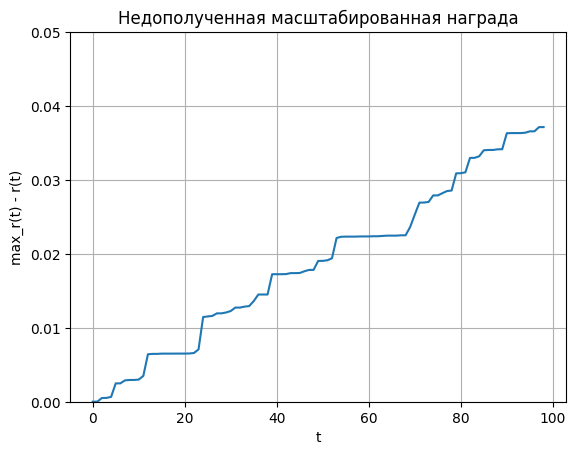

In [34]:
lost_rewards_percent = np.cumsum(lost_rewards) / T / (max_reward - min_reward)

plt.title('Недополученная масштабированная награда')
plt.xlabel('t')
plt.ylabel('max_r(t) - r(t)')
plt.grid()
plt.ylim([0, 0.05])
plt.plot(np.arange(T - 1), lost_rewards_percent)
plt.show()

# Сравнение

In [36]:
with open('/content/drive/MyDrive/marl/4/data.pickle', 'rb') as f:
   reward_values_easy, loss_values_easy = pickle.load(f)

with open('/content/drive/MyDrive/marl/5/data.pickle', 'rb') as f:
   reward_values_hard, loss_values_hard = pickle.load(f)

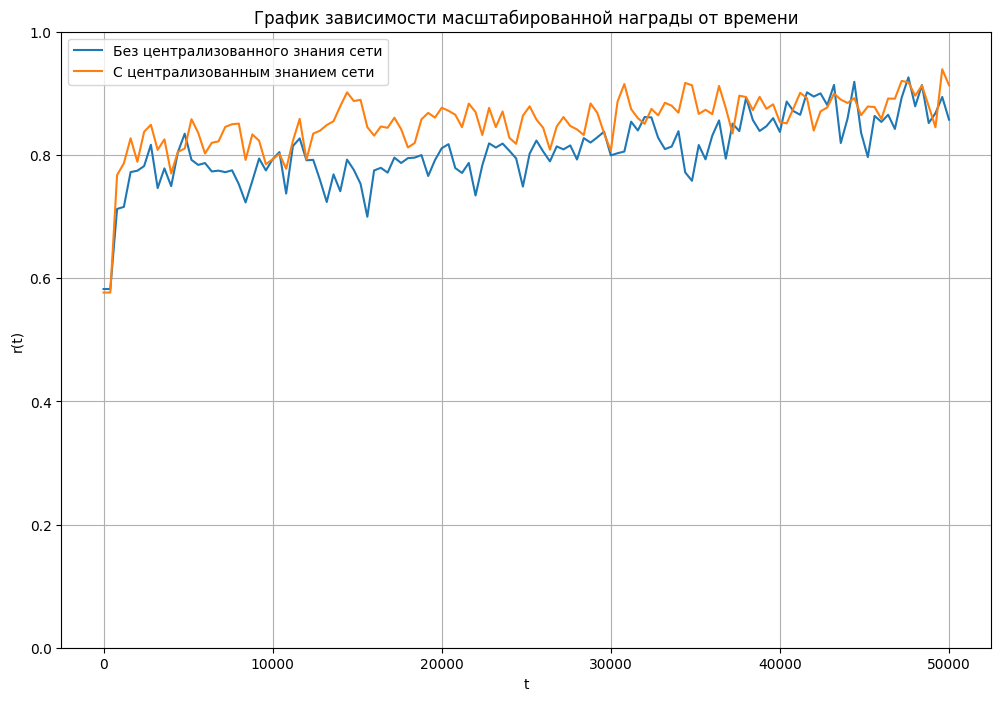

In [37]:
x = range(0, total_steps, eval_freq)
reward_values_hard = reward_values

plt.figure(figsize=(12, 8))
plt.title('График зависимости масштабированной награды от времени')
plt.xlabel('t')
plt.ylabel('r(t)')
plt.grid()
plt.ylim([0, 1])
plt.plot(x, reward_values_hard, label='Без централизованного знания сети')
plt.plot(x, reward_values_easy, label='С централизованным знанием сети')
plt.legend()
plt.show()